In [1]:
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install tqdm
!pip install seaborn
!pip install matplotlib
!pip install plotly
!pip install scipy
!pip install statsmodels
!pip install prophet
!pip install torch torchvision torchaudio

In [2]:
import gc
import time
import math
from math import log, floor
import datetime

import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import Normalize
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import scipy
from scipy import signal
from scipy.signal import butter, deconvolve

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from prophet import Prophet

import torch
import torch.nn as nn

In [3]:
import plotly.io as pio
pio.renderers.default = 'colab'

#
**Load data**

In [5]:
calendar = pd.read_csv('/content/calendar.csv')
selling_prices = pd.read_csv('/content/sell_prices.csv')
sample_submission = pd.read_csv('/content/sample_submission.csv')
sales_train_val = pd.read_csv('/content/sales_train_validation.csv')

#
**Sales data**\
Contains the historical daily unit sales data per product and store [d_1 - d_1913].

In [6]:
sales_train_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [7]:
# product and store
ids = sorted(list(set(sales_train_val['id'])))
ids[2], ids[1], ids[65]

('FOODS_1_001_CA_3_validation',
 'FOODS_1_001_CA_2_validation',
 'FOODS_1_008_TX_2_validation')

In [8]:
d_cols = [c for c in sales_train_val.columns if 'd_' in c]
d_cols[:5]

['d_1', 'd_2', 'd_3', 'd_4', 'd_5']

In [9]:
x_1 = sales_train_val.loc[sales_train_val['id'] == ids[2]].set_index('id')[d_cols].values[0]
x_2 = sales_train_val.loc[sales_train_val['id'] == ids[1]].set_index('id')[d_cols].values[0]
x_3 = sales_train_val.loc[sales_train_val['id'] == ids[17]].set_index('id')[d_cols].values[0]

In [10]:
x_1.max()

np.int64(24)

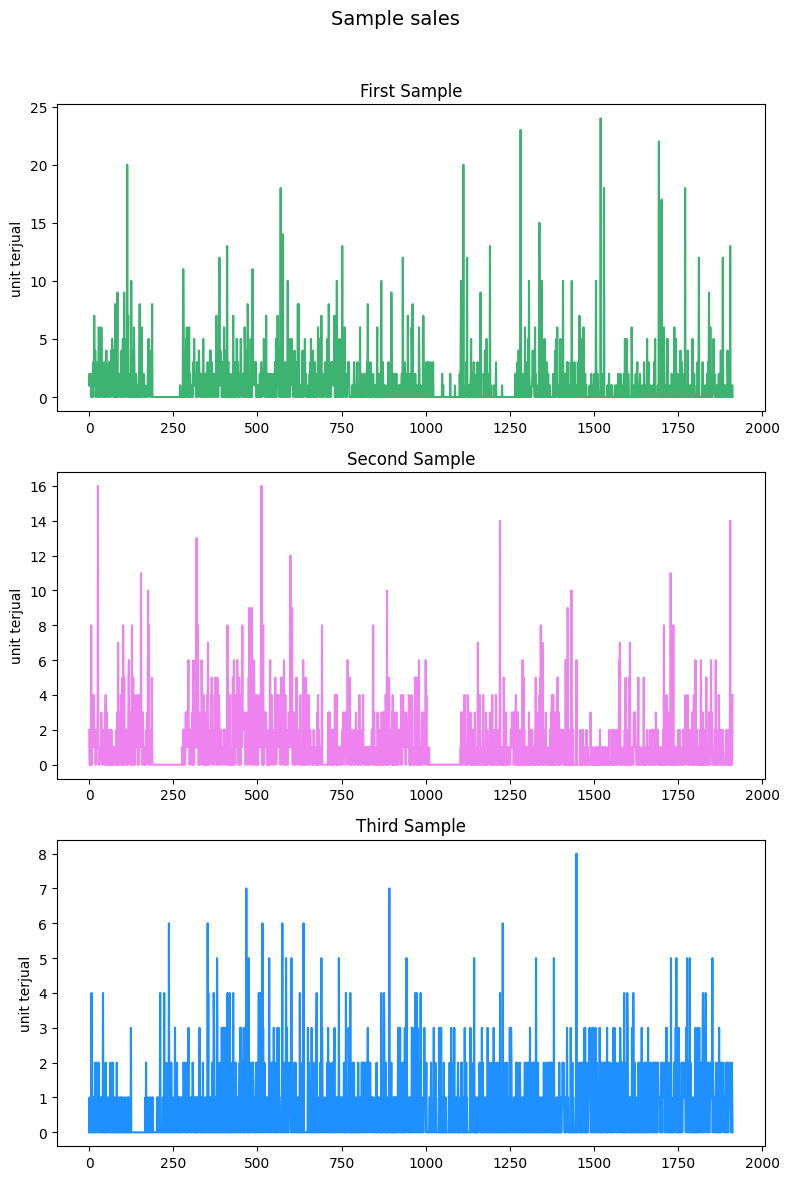

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# subplot 1
axes[0].plot(np.arange(len(x_1)), x_1, color="mediumseagreen")
axes[0].set_ylabel("unit terjual")
axes[0].set_title("First Sample")

# subplot 2
axes[1].plot(np.arange(len(x_2)), x_2, color="violet")
axes[1].set_ylabel("unit terjual")
axes[1].set_title("Second Sample")

# subplot 3
axes[2].plot(np.arange(len(x_3)), x_3, color="dodgerblue")
axes[2].set_ylabel("unit terjual")
axes[2].set_title("Third Sample")

fig.suptitle("Sample sales", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

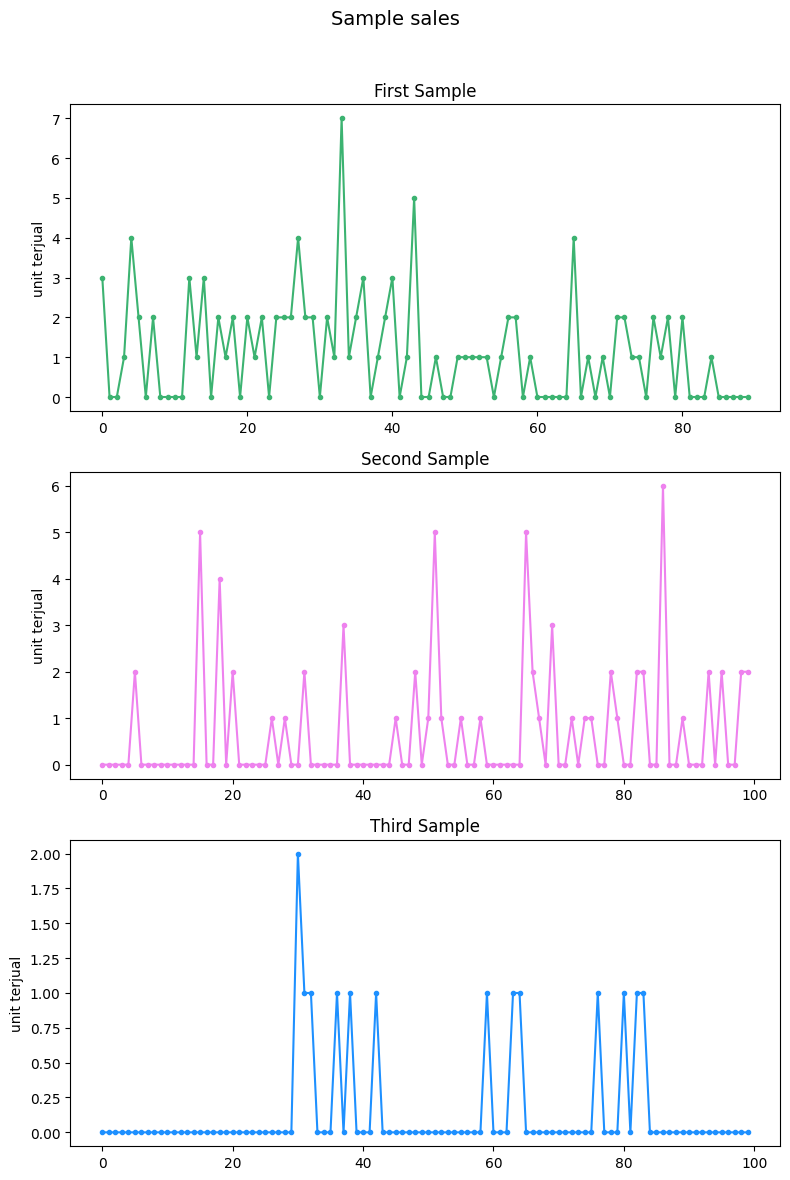

In [12]:
x_1 = sales_train_val.loc[sales_train_val['id'] == ids[0]].set_index('id')[d_cols].values[0][:90]
x_2 = sales_train_val.loc[sales_train_val['id'] == ids[4]].set_index('id')[d_cols].values[0][1300:1400]
x_3 = sales_train_val.loc[sales_train_val['id'] == ids[65]].set_index('id')[d_cols].values[0][350:450]

fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# subplot 1
axes[0].plot(np.arange(len(x_1)), x_1, ".-",color="mediumseagreen")
axes[0].set_ylabel("unit terjual")
axes[0].set_title("First Sample")

# subplot 2
axes[1].plot(np.arange(len(x_2)), x_2, ".-",color="violet")
axes[1].set_ylabel("unit terjual")
axes[1].set_title("Second Sample")

# subplot 3
axes[2].plot(np.arange(len(x_3)), x_3, ".-",color="dodgerblue")
axes[2].set_ylabel("unit terjual")
axes[2].set_title("Third Sample")

fig.suptitle("Sample sales", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In the above plots, I simply zoom in to sample snippets in the sales data. As stated earlier, we can clearly see that the sales data is very erratic and volatile. Sometimes, the sales are zero for a few days in a row, and at other times, it remains at its peak value for a few days. Therefore, we need some sort of "denoising" techniques to find the underlying trends in the sales data and make forecasts.
#
**Denoising**\
Now, I will show how these volatile sales prices can be denoised in order to extract underlying trends. This method may lose some information from the original time series, but it may be useful in extracting certain features regarding the trends in the time series.

Wavelet denoising\
Wavelet denoising (usually used with electric signals) is a way to remove the unnecessary noise from a time series. This method calculates coefficients called the "wavelet coefficients". These coefficients decide which pieces of information to keep (signal) and which ones to discard (noise).

We make use of the MAD (mean absolute deviation) value to understand the randomness in the sales and accordingly decide the minimum threshold for the wavelet coefficients in the time series. We filter out the low coefficients from the wavelets and reconstruct the sales data from the remaining coefficients and that's it; we have successfully removed noise from the sales data.

In [13]:
import pywt

In [14]:
coeff = pywt.wavedec(x_1, wavelet='db4', mode='per')
sigma_1 = (1/0.6745) * np.mean(np.absolute((coeff[-1] - np.mean(coeff[-1]))))

In [15]:
unthresh_1 = sigma_1 * np.sqrt(2*np.log(len(x_1)))
coeff_1 = coeff
coeff_1[1:] = (pywt.threshold(i, value=unthresh_1, mode='hard') for i in coeff_1[1:])

In [16]:
y_x1_1 = pywt.waverec(coeff_1, "db4", mode="per")

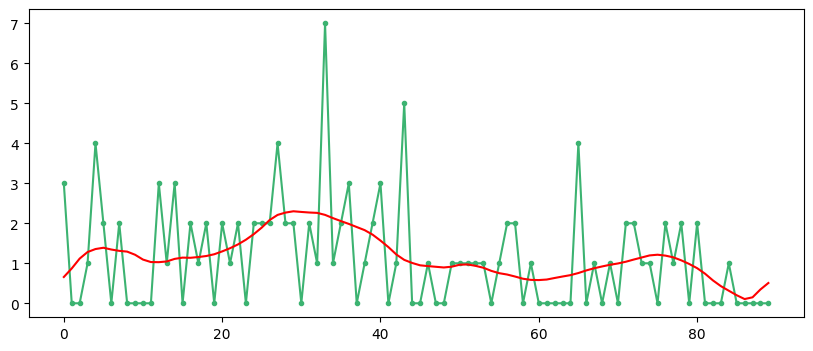

In [17]:
plt.figure(figsize=(10,4))
plt.plot(np.arange(len(x_1)), x_1, ".-", color="mediumseagreen")
plt.plot(np.arange(len(x_1)), y_x1_1, "red");

In [18]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per')

In [19]:
y_w1 = denoise_signal(x_1)
y_w2 = denoise_signal(x_2)
y_w3 = denoise_signal(x_3)

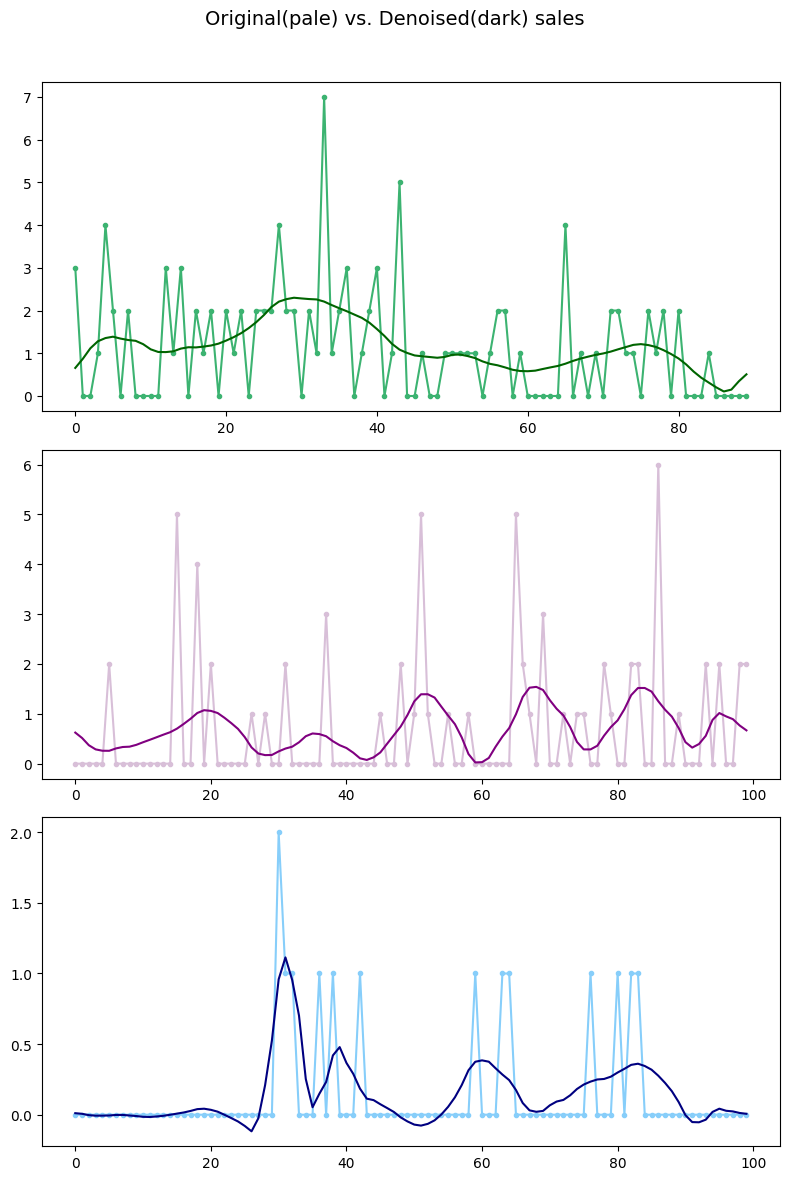

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# subplot 1
axes[0].plot(np.arange(len(x_1)), x_1, ".-",color="mediumseagreen")
axes[0].plot(np.arange(len(x_1)), y_w1,color="darkgreen")

# subplot 2
axes[1].plot(np.arange(len(x_2)), x_2, ".-",color="thistle")
axes[1].plot(np.arange(len(x_2)), y_w2,color="purple")

# subplot 3
axes[2].plot(np.arange(len(x_3)), x_3, ".-",color="lightskyblue")
axes[2].plot(np.arange(len(x_3)), y_w3,color="navy")

fig.suptitle("Original(pale) vs. Denoised(dark) sales", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

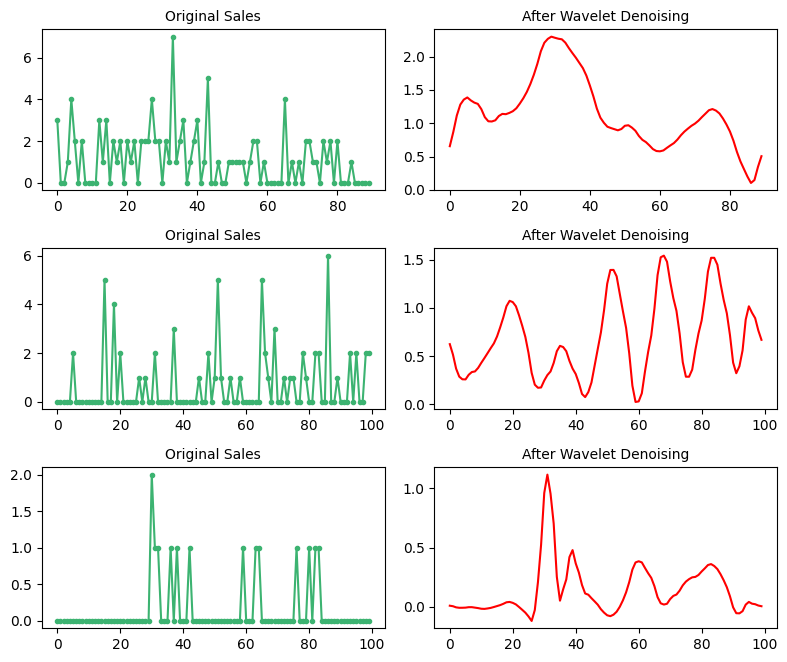

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(8, 7))

# subplot 1
axes[0,0].plot(np.arange(len(x_1)), x_1, ".-",color="mediumseagreen")
axes[0,0].set_title('Original Sales', fontsize=10)

axes[0,1].plot(np.arange(len(x_1)), y_w1,color="red")
axes[0, 1].set_title('After Wavelet Denoising', fontsize=10)

# subplot 2
axes[1,0].plot(np.arange(len(x_2)), x_2, ".-",color="mediumseagreen")
axes[1,0].set_title('Original Sales', fontsize=10)

axes[1,1].plot(np.arange(len(x_2)), y_w2,color="red")
axes[1, 1].set_title('After Wavelet Denoising', fontsize=10)

# subplot 3
axes[2,0].plot(np.arange(len(x_3)), x_3, ".-",color="mediumseagreen")
axes[2,0].set_title('Original Sales', fontsize=10)

axes[2,1].plot(np.arange(len(x_3)), y_w3,color="red")
axes[2,1].set_title('After Wavelet Denoising', fontsize=10)

# fig.suptitle("Original(pale) vs. Denoised(dark) sales", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#
**Average Smoothing**\
Average smooting is a relatively simple way to denoise time series data. In this method, we take a "window" with a fixed size (like 10). We first place the window at the beginning of the time series (first ten elements) and calculate the mean of that section. We now move the window across the time series in the forward direction by a particular "stride", calculate the mean of the new window and repeat the process, until we reach the end of the time series. All the mean values we calculated are then concatenated into a new time series, which forms the denoised sales data.

In [22]:
def average_smoothing(signal, kernel_size=3, stride=1):
    sample = []
    start = 0
    end = kernel_size

    while end <= len(signal):
        start = start + stride
        end = end + stride
        sample.extend(np.ones(end - start)*np.mean(signal[start:end]))
    return np.array(sample)

In [23]:
y_a1 = average_smoothing(x_1)
y_a2 = average_smoothing(x_2)
y_a3 = average_smoothing(x_3)

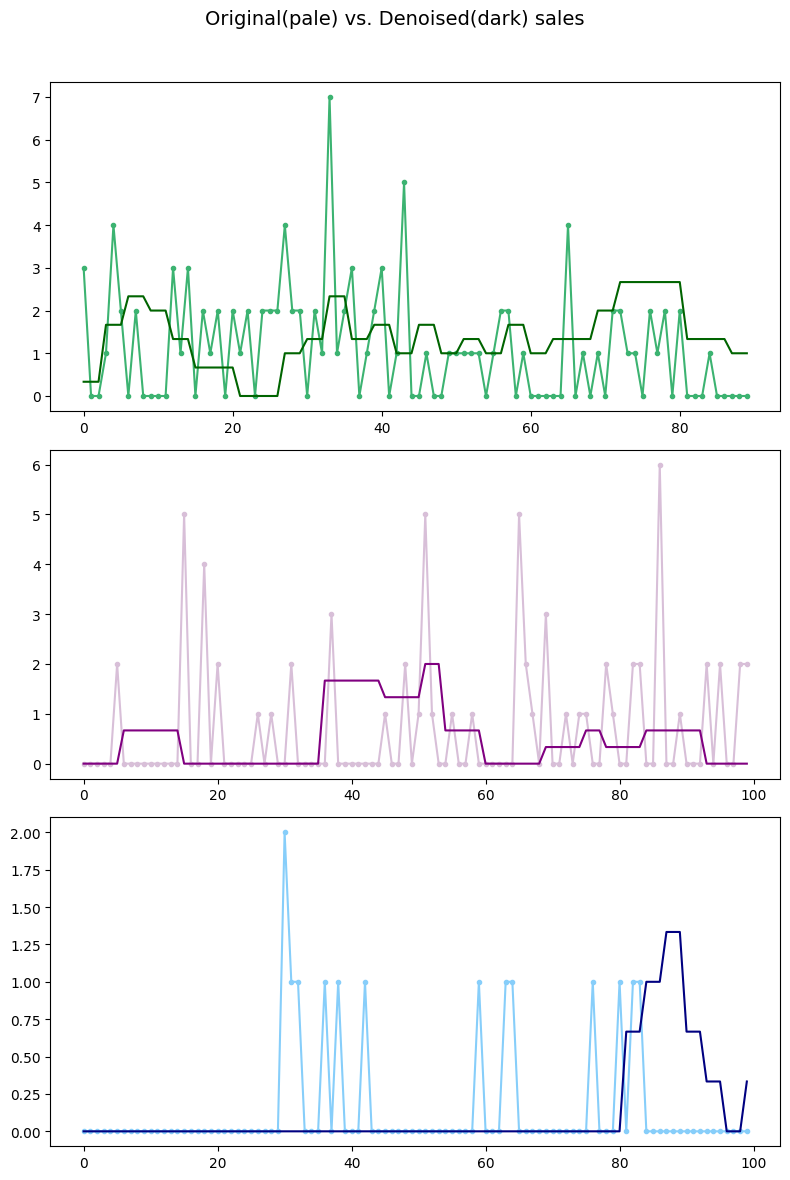

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# subplot 1
axes[0].plot(np.arange(len(x_1)), x_1, ".-",color="mediumseagreen")
axes[0].plot(np.arange(len(x_1)), y_a1[:len(x_1)],color="darkgreen")

# subplot 2
axes[1].plot(np.arange(len(x_2)), x_2, ".-",color="thistle")
axes[1].plot(np.arange(len(x_2)), y_a2[:len(x_2)],color="purple")

# subplot 3
axes[2].plot(np.arange(len(x_3)), x_3, ".-",color="lightskyblue")
axes[2].plot(np.arange(len(x_3)), y_a3[:len(x_3)],color="navy")

fig.suptitle("Original(pale) vs. Denoised(dark) sales", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In the above graphs, the dark lineplots represent the denoised sales and the light lineplots represent the original sales. We can see that average smoothing is not as effective as Wavelet denoising at finding macroscopic trends and pattersns in the data. A lot of the noise in the original sales persists even after denoising. Therefore, wavelet denoising is clearly more effective at finding trends in the sales data. Nonetheless, average smoothing or "rolling mean" can also be used to calculate useful features for modeling.

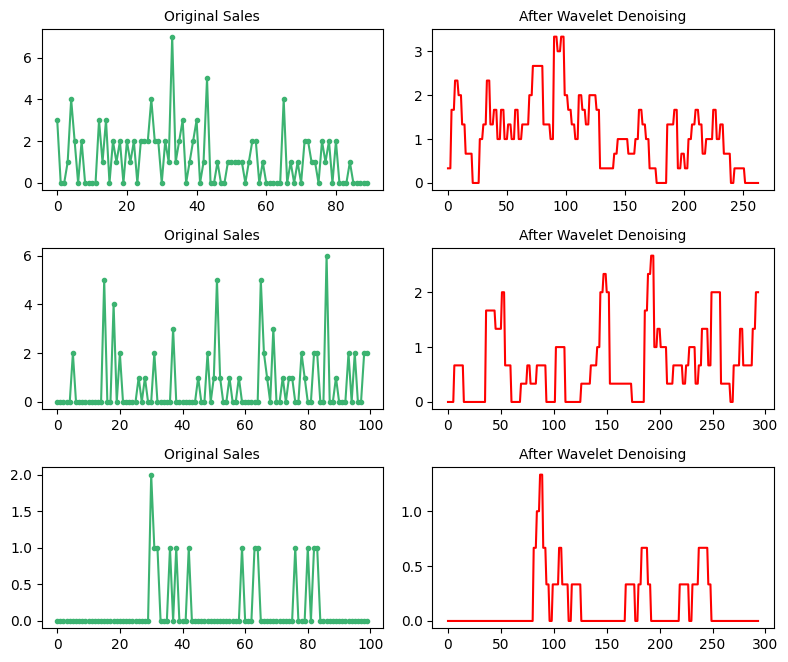

In [25]:
fig, axes = plt.subplots(3, 2, figsize=(8, 7))

# subplot 1
axes[0,0].plot(np.arange(len(x_1)), x_1, ".-",color="mediumseagreen")
axes[0,0].set_title('Original Sales', fontsize=10)

axes[0,1].plot(np.arange(len(y_a1)), y_a1,color="red")
axes[0, 1].set_title('After Wavelet Denoising', fontsize=10)

# subplot 2
axes[1,0].plot(np.arange(len(x_2)), x_2, ".-",color="mediumseagreen")
axes[1,0].set_title('Original Sales', fontsize=10)

axes[1,1].plot(np.arange(len(y_a2)), y_a2,color="red")
axes[1, 1].set_title('After Wavelet Denoising', fontsize=10)

# subplot 3
axes[2,0].plot(np.arange(len(x_3)), x_3, ".-",color="mediumseagreen")
axes[2,0].set_title('Original Sales', fontsize=10)

axes[2,1].plot(np.arange(len(y_a3)), y_a3,color="red")
axes[2,1].set_title('After Wavelet Denoising', fontsize=10)

# fig.suptitle("Original(pale) vs. Denoised(dark) sales", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#
**Stores and states**\
Now, I will look at the sales data across different stores and states in order to gain some useful insights.

In [26]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [27]:
past_sales = sales_train_val.set_index('id')[d_cols].T.merge(calendar.set_index('d')['date'],
                                               left_index = True,
                                               right_index = True,
                                               validate = "1:1").set_index('date')

In [28]:
selling_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


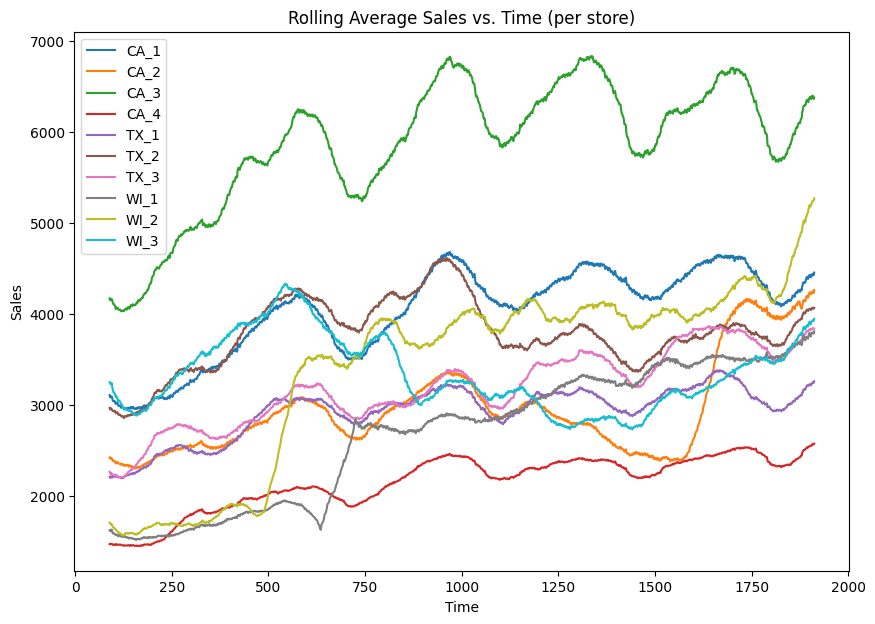

In [29]:
store_list = selling_prices['store_id'].unique()
means = []

plt.figure(figsize=(10,7))
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    means.append(np.mean(past_sales[store_items].sum(axis=1)))
    plt.plot(np.arange(len(data)), data, label=s)
    plt.legend()
plt.xlabel("Time")
plt.ylabel("Sales")
plt.title("Rolling Average Sales vs. Time (per store)")
plt.show()

 Almost every sales curve has "linear oscillation" trend at the macroscopic level. Basically, the sales oscillate like a sine wave about a certain mean value, but this mean value has an upward linear trend. This implies that the sales are oscillating at a higher and higher level every few months.

This trend is reminiscent of the business cycle, where economies have short-term oscillatory fluctuations but grow linearly in the long run. Maybe, such small-scale trends at the level of stores add up to decide trends we see at the macroeconomic level. Below is an illustration of the macroeconomic business cycle:

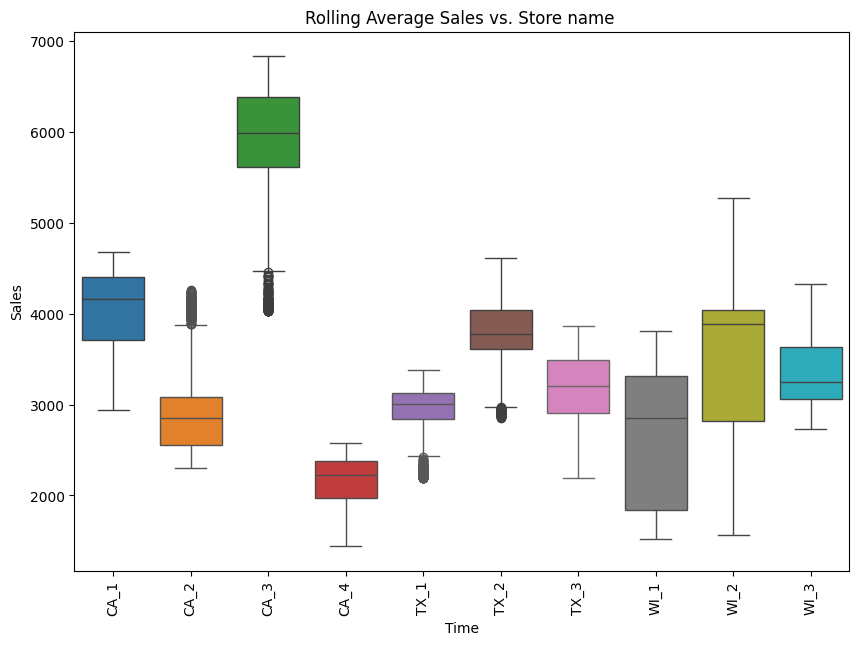

In [30]:
plt.figure(figsize=(10,7))
for i, s in enumerate(store_list):
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    sns.boxplot(x = [s]*len(data), y = data)
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Sales")
plt.title("Rolling Average Sales vs. Store name ")
plt.show()

The above plot compares the sales distribution for each store in the dataset. The stores in California seem to have the highest variance in sales, which might indicate that some places in California grow significantly faster than others, i.e. there is development disparity. On the other hand, the Wisconsin and Texas sales seem to be quite consistent among themselves, without much variance. This indicates that development might be more uniform in these states. Moreover, the California stores also seem to have the highest overall mean sales

In [31]:
# plt.figure(figsize=(10,7))
df = pd.DataFrame(np.transpose([means, store_list]))
df.columns = ["Mean sales", "Store name"]
fig = px.bar(df, x="Store name", y="Mean sales", color="Store name",
             title="Mean sales vs. Store name")
fig.update_layout(yaxis_title="Sales", xaxis_title="Time",
                  title="Rolling Average Sales vs. Store name ")
fig.show();

From the above graph, we can see the same trends: California stores have the highest variance and mean sales among all the stores in the dataset.

In [32]:
greens = ["mediumaquamarine", "mediumseagreen", "seagreen", "green"]

fig = go.Figure()
means = []
stores = []

for i, s in enumerate(store_list):
    if "ca" in s or "CA" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        means.append(np.mean(past_sales[store_items].sum(axis=1)))
        stores.append(s)

        fig.add_trace(go.Scatter(x = np.arange(len(data)), y=data, name=s,
                                 marker = dict(color=greens[i])))

fig.update_layout(yaxis_title="Sales", xaxis_title="Time",
                  title="Rolling Average Sales vs. Time (California)")

In the above graph, we can see the large disparity in sales among California stores. The sales curves almost never intersect each other. This may indicate that there are certain "hubs" of development in California which do not change over time. And other areas always remain behind these "hubs". The average sales in descending order are CA_3, CA_1, CA_2, CA_4. The store CA_3 has maximum sales while the store CA_4 has minimum sales.

#
## **Modelling**
**Train/Val Split**

In [33]:
train_set = sales_train_val[d_cols[-100:-30]]
val_set = sales_train_val[d_cols[-30:]]

In [34]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x = np.arange(70),
                         mode = 'lines',
                         y = train_set.loc[0].values,
                         marker = dict(color='dodgerblue'),
                    showlegend=False,
                    name = "Original Signal"),
             row=1, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = val_set.loc[0].values,
                         marker = dict(color='darkorange'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=1, col=1)

fig.add_trace(go.Scatter(x = np.arange(70),
                         mode = 'lines',
                         y = train_set.loc[1].values,
                         marker = dict(color='dodgerblue'),
                    showlegend=False,
                    name = "Original Signal"),
             row=2, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = val_set.loc[1].values,
                         marker = dict(color='darkorange'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=2, col=1)

fig.add_trace(go.Scatter(x = np.arange(70),
                         mode = 'lines',
                         y = train_set.loc[2].values,
                         marker = dict(color='dodgerblue'),
                    showlegend=False,
                    name = "Original Signal"),
             row=3, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = val_set.loc[2].values,
                         marker = dict(color='darkorange'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=3, col=1)

fig.update_layout(height=1200, width=800,
                  title_text="Train (blue) vs. Validation (orange) sales")
fig.show()

#
**Naive Approach**

In [35]:
predictions = []
for i in range(len(val_set.columns)):
    if i == 0:
        predictions.append(train_set[train_set.columns[-1]].values)
    else:
        predictions.append(val_set[val_set.columns[i-1]].values)

predictions = np.transpose(np.array([row.tolist() for row in predictions]))
error_naive = np.linalg.norm(predictions[:3] - val_set.values[:3])/len(predictions[0])

In [36]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

#########################################
fig.add_trace(go.Scatter(x = np.arange(70),
                         mode = 'lines',
                         y = train_set.loc[0].values,
                         marker = dict(color='dodgerblue'),
                    showlegend=False,
                    name = "Original Signal"),
             row=1, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = val_set.loc[0].values,
                         marker = dict(color='darkorange'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=1, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = pred_1,
                         marker = dict(color='seagreen'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=1, col=1)

#########################################
fig.add_trace(go.Scatter(x = np.arange(70),
                         mode = 'lines',
                         y = train_set.loc[1].values,
                         marker = dict(color='dodgerblue'),
                    showlegend=False,
                    name = "Original Signal"),
             row=2, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = val_set.loc[1].values,
                         marker = dict(color='darkorange'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=2, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = pred_2,
                         marker = dict(color='seagreen'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=2, col=1)

#########################################

fig.add_trace(go.Scatter(x = np.arange(70),
                         mode = 'lines',
                         y = train_set.loc[2].values,
                         marker = dict(color='dodgerblue'),
                    showlegend=False,
                    name = "Original Signal"),
             row=3, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = val_set.loc[2].values,
                         marker = dict(color='darkorange'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=3, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = pred_3,
                         marker = dict(color='seagreen'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=3, col=1)

#########################################

fig.update_layout(height=1200, width=800,
                  title_text="Train (blue) vs. Validation (orange) sales")
fig.show()

#
**Moving Average**

In [37]:
predictions = []

for i in range(len(val_set.columns)):
    if i == 0:
        predictions.append(np.mean(train_set[train_set.columns[-30:]].values, axis=1))
    if i < 31 and i > 0 :
        predictions.append(0.5 * (np.mean(train_set[train_set.columns[-30+i:]].values, axis=1) + np.mean(predictions[:i], axis=0)))
    if i > 31:
        predictions.append(np.mean([predictions[i]], axis=1))

predictions = np.transpose(np.array([row.tolist() for row in predictions]))
error_avg = np.linalg.norm(predictions[:3] - val_set.values[:3])/len(predictions[0])

In [38]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

#########################################
fig.add_trace(go.Scatter(x = np.arange(70),
                         mode = 'lines',
                         y = train_set.loc[0].values,
                         marker = dict(color='dodgerblue'),
                    showlegend=False,
                    name = "Original Signal"),
             row=1, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = val_set.loc[0].values,
                         marker = dict(color='darkorange'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=1, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = pred_1,
                         marker = dict(color='seagreen'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=1, col=1)

#########################################
fig.add_trace(go.Scatter(x = np.arange(70),
                         mode = 'lines',
                         y = train_set.loc[1].values,
                         marker = dict(color='dodgerblue'),
                    showlegend=False,
                    name = "Original Signal"),
             row=2, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = val_set.loc[1].values,
                         marker = dict(color='darkorange'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=2, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = pred_2,
                         marker = dict(color='seagreen'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=2, col=1)

#########################################

fig.add_trace(go.Scatter(x = np.arange(70),
                         mode = 'lines',
                         y = train_set.loc[2].values,
                         marker = dict(color='dodgerblue'),
                    showlegend=False,
                    name = "Original Signal"),
             row=3, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = val_set.loc[2].values,
                         marker = dict(color='darkorange'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=3, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = pred_3,
                         marker = dict(color='seagreen'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=3, col=1)

#########################################

fig.update_layout(height=1200, width=800,
                  title_text="Train (blue) vs. Validation (orange) sales")
fig.show()

#
**Holt Linear**

In [39]:
predictions = []
for row in tqdm(train_set[train_set.columns[-30:]].values[:3]):
    fit = Holt(row).fit(smoothing_level = 0.3, smoothing_slope = 0.01)
    predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape((-1, 30))
error_holt = np.linalg.norm(predictions - val_set.values[:len(predictions)])/len(predictions[0])

  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipython-input-1755212092.py:3: FutureWarning:

the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.

/usr/local/lib/python3.12/dist-packages/pandas/util/_decorators.py:213: EstimationWarning:

Model has no free parameters to estimate. Set optimized=False to suppress this warning

/tmp/ipython-input-1755212092.py:3: FutureWarning:

the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.

/usr/local/lib/python3.12/dist-packages/pandas/util/_decorators.py:213: EstimationWarning:

Model has no free parameters to estimate. Set optimized=False to suppress this warning

/tmp/ipython-input-1755212092.py:3: FutureWarning:

the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.

/usr/local/lib/python3.12/dist-packages/pandas/util/_decorators.py:213: EstimationWarning:

Model has no free parameters to estimate. Set optimized=False to suppress this warning

100%|██████████| 3/3 [00:00<00:00, 2

In [40]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

#########################################
fig.add_trace(go.Scatter(x = np.arange(70),
                         mode = 'lines',
                         y = train_set.loc[0].values,
                         marker = dict(color='dodgerblue'),
                    showlegend=False,
                    name = "Original Signal"),
             row=1, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = val_set.loc[0].values,
                         marker = dict(color='darkorange'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=1, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = pred_1,
                         marker = dict(color='seagreen'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=1, col=1)

#########################################
fig.add_trace(go.Scatter(x = np.arange(70),
                         mode = 'lines',
                         y = train_set.loc[1].values,
                         marker = dict(color='dodgerblue'),
                    showlegend=False,
                    name = "Original Signal"),
             row=2, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = val_set.loc[1].values,
                         marker = dict(color='darkorange'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=2, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = pred_2,
                         marker = dict(color='seagreen'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=2, col=1)

#########################################

fig.add_trace(go.Scatter(x = np.arange(70),
                         mode = 'lines',
                         y = train_set.loc[2].values,
                         marker = dict(color='dodgerblue'),
                    showlegend=False,
                    name = "Original Signal"),
             row=3, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = val_set.loc[2].values,
                         marker = dict(color='darkorange'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=3, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = pred_3,
                         marker = dict(color='seagreen'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=3, col=1)

#########################################

fig.update_layout(height=1200, width=800,
                  title_text="Train (blue) vs. Validation (orange) sales")
fig.show()

#
**Exponential smoothing**

In [41]:
predictions = []
for row in tqdm(train_set[train_set.columns[-30:]].values[:3]):
    fit = ExponentialSmoothing(row, seasonal_periods=3).fit()
    predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape((-1, 30))
error_exponential = np.linalg.norm(predictions[:3] - val_set.values[:3])/len(predictions[0])

100%|██████████| 3/3 [00:00<00:00, 71.63it/s]


In [42]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

#########################################
fig.add_trace(go.Scatter(x = np.arange(70),
                         mode = 'lines',
                         y = train_set.loc[0].values,
                         marker = dict(color='dodgerblue'),
                    showlegend=False,
                    name = "Original Signal"),
             row=1, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = val_set.loc[0].values,
                         marker = dict(color='darkorange'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=1, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = pred_1,
                         marker = dict(color='seagreen'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=1, col=1)

#########################################
fig.add_trace(go.Scatter(x = np.arange(70),
                         mode = 'lines',
                         y = train_set.loc[1].values,
                         marker = dict(color='dodgerblue'),
                    showlegend=False,
                    name = "Original Signal"),
             row=2, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = val_set.loc[1].values,
                         marker = dict(color='darkorange'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=2, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = pred_2,
                         marker = dict(color='seagreen'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=2, col=1)

#########################################

fig.add_trace(go.Scatter(x = np.arange(70),
                         mode = 'lines',
                         y = train_set.loc[2].values,
                         marker = dict(color='dodgerblue'),
                    showlegend=False,
                    name = "Original Signal"),
             row=3, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = val_set.loc[2].values,
                         marker = dict(color='darkorange'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=3, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = pred_3,
                         marker = dict(color='seagreen'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=3, col=1)

#########################################

fig.update_layout(height=1200, width=800,
                  title_text="Train (blue) vs. Validation (orange) sales")
fig.show()

#
**ARIMA**

In [43]:
predictions = []
for row in tqdm(train_set[train_set.columns[-30:]].values[:3]):
    ffit = sm.tsa.statespace.SARIMAX(
                row,
                order=(1,1,1),
                seasonal_order=(1,1,1,7),
                enforce_invertibility=False
            ).fit(method='lbfgs', maxiter=200, disp=False)
    predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape((-1, 30))
error_arima = np.linalg.norm(predictions[:3] - val_set.values[:3])/len(predictions[0])

100%|██████████| 3/3 [00:00<00:00,  4.38it/s]


In [44]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

#########################################
fig.add_trace(go.Scatter(x = np.arange(70),
                         mode = 'lines',
                         y = train_set.loc[0].values,
                         marker = dict(color='dodgerblue'),
                    showlegend=False,
                    name = "Original Signal"),
             row=1, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = val_set.loc[0].values,
                         marker = dict(color='darkorange'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=1, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = pred_1,
                         marker = dict(color='seagreen'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=1, col=1)

#########################################
fig.add_trace(go.Scatter(x = np.arange(70),
                         mode = 'lines',
                         y = train_set.loc[1].values,
                         marker = dict(color='dodgerblue'),
                    showlegend=False,
                    name = "Original Signal"),
             row=2, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = val_set.loc[1].values,
                         marker = dict(color='darkorange'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=2, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = pred_2,
                         marker = dict(color='seagreen'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=2, col=1)

#########################################

fig.add_trace(go.Scatter(x = np.arange(70),
                         mode = 'lines',
                         y = train_set.loc[2].values,
                         marker = dict(color='dodgerblue'),
                    showlegend=False,
                    name = "Original Signal"),
             row=3, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = val_set.loc[2].values,
                         marker = dict(color='darkorange'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=3, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = pred_3,
                         marker = dict(color='seagreen'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=3, col=1)

#########################################

fig.update_layout(height=1200, width=800,
                  title_text="Train (blue) vs. Validation (orange) sales")
fig.show()

#
**Prophet**

In [45]:
dates = ["2007-12-" + str(i) for i in range(1, 31)]
predictions = []
for row in tqdm(train_set[train_set.columns[-30:]].values[:3]):
    df = pd.DataFrame(np.transpose([dates, row]))
    df.columns = ["ds", "y"]
    model = Prophet(daily_seasonality=True)
    model.fit(df)
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)["yhat"].loc[30:].values
    predictions.append(forecast)
predictions = np.array(predictions).reshape((-1, 30))
error_prophet = np.linalg.norm(predictions[:3] - val_set.values[:3])/len(predictions[0])

  0%|          | 0/3 [00:00<?, ?it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7krp76ta/6t8gt4hf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7krp76ta/yjavknw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50745', 'data', 'file=/tmp/tmp7krp76ta/6t8gt4hf.json', 'init=/tmp/tmp7krp76ta/yjavknw6.json', 'output', 'file=/tmp/tmp7krp76ta/prophet_modelmd2yj7o4/prophet_model-20250918181845.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:18:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:18:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
 33%|███▎      | 1/3 [00:00

In [46]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

#########################################
fig.add_trace(go.Scatter(x = np.arange(70),
                         mode = 'lines',
                         y = train_set.loc[0].values,
                         marker = dict(color='dodgerblue'),
                    showlegend=False,
                    name = "Original Signal"),
             row=1, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = val_set.loc[0].values,
                         marker = dict(color='darkorange'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=1, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = pred_1,
                         marker = dict(color='seagreen'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=1, col=1)

#########################################
fig.add_trace(go.Scatter(x = np.arange(70),
                         mode = 'lines',
                         y = train_set.loc[1].values,
                         marker = dict(color='dodgerblue'),
                    showlegend=False,
                    name = "Original Signal"),
             row=2, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = val_set.loc[1].values,
                         marker = dict(color='darkorange'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=2, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = pred_2,
                         marker = dict(color='seagreen'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=2, col=1)

#########################################

fig.add_trace(go.Scatter(x = np.arange(70),
                         mode = 'lines',
                         y = train_set.loc[2].values,
                         marker = dict(color='dodgerblue'),
                    showlegend=False,
                    name = "Original Signal"),
             row=3, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = val_set.loc[2].values,
                         marker = dict(color='darkorange'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=3, col=1)

fig.add_trace(go.Scatter(x = np.arange(70,100),
                         mode = 'lines',
                         y = pred_3,
                         marker = dict(color='seagreen'),
                    showlegend=False,
                    name = "Denoised Signal"),
             row=3, col=1)

#########################################

fig.update_layout(height=1200, width=800,
                  title_text="Train (blue) vs. Validation (orange) sales")
fig.show()

In [47]:
errors = [error_naive, error_avg, error_holt, error_exponential, error_arima, error_prophet]
names  = ['Naive approach', 'Moving average', 'Holt linear', 'Exponential smoothing', 'ARIMA', 'Prophet']

rmse = [float(np.squeeze(e)) for e in errors]

df = pd.DataFrame({
    "Model": names,
    "RMSE Loss": rmse
})
df = df.sort_values("RMSE Loss", ascending=True)

fig = px.bar(df, x="Model", y="RMSE Loss", color="Model", title="RMSE Loss vs. Model", text="RMSE Loss")
fig.update_traces(texttemplate="%{text:.3f}", textposition="outside")
fig.update_xaxes(categoryorder="array", categoryarray=df["Model"])

fig.show()

In [48]:
df

,Model,RMSE Loss
3,Exponential smoothing,0.243052
1,Moving average,0.248707
4,ARIMA,0.264435
5,Prophet,0.301499
0,Naive approach,0.303681
2,Holt linear,3.876338


In [49]:
df.sort_values(by='RMSE Loss')

,Model,RMSE Loss
3,Exponential smoothing,0.243052
1,Moving average,0.248707
4,ARIMA,0.264435
5,Prophet,0.301499
0,Naive approach,0.303681
2,Holt linear,3.876338


In [50]:
train_set

,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883
0,0,0,0,2,1,2,1,0,0,0,...,1,1,3,1,3,1,2,2,0,1
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,3,2,4,3,1,2,3,0,8,2,...,1,3,4,2,1,4,1,3,5,0
4,0,1,0,0,0,1,0,0,3,0,...,1,0,3,2,2,2,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,0,0,0,0,1,0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
30486,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30487,3,1,0,2,0,0,0,1,1,0,...,1,1,2,0,0,2,0,0,0,2
30488,0,4,4,2,2,1,1,2,0,1,...,1,1,1,1,1,1,0,2,1,1


In [51]:
import pandas as pd

# melt data (ubah wide ke long)
df_long_train = pd.melt(train_set.reset_index(),
                        id_vars=['index'],   # atau pakai 'id' kalau ada
                        var_name='day',
                        value_name='demand'
                    )
df_long_test = pd.melt(val_set.reset_index(),
                        id_vars=['index'],   # atau pakai 'id' kalau ada
                        var_name='day',
                        value_name='demand'
                    )

In [52]:
df_long_train

,index,day,demand
0,0,d_1814,0
1,1,d_1814,0
2,2,d_1814,0
3,3,d_1814,3
4,4,d_1814,0
...,...,...,...
2134295,30485,d_1883,0
2134296,30486,d_1883,0
2134297,30487,d_1883,2
2134298,30488,d_1883,1


In [53]:
import numpy as np

def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

def X_y(df_long, idx=None):
    if idx is not None:
        series = df_long[df_long['index']==idx]['demand'].values
    else:
        series = df_long['demand'].values
    X, y = create_sequences(series, window_size=30)
    return X,y

X_train,y_train = X_y(df_long_train)
X_test,y_test = X_y(df_long_test)

In [54]:

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2134270, 30), (2134270,), (914670, 30), (914670,))

In [55]:
# ambil 100 sample pertama
X_train_small = X_train[:150]
y_train_small = y_train[:150]

X_test_small = X_test[:150]
y_test_small = y_test[:150]

print(X_train_small.shape, y_train_small.shape)
print(X_test_small.shape, y_test_small.shape)


(150, 30) (150,)
(150, 30) (150,)


In [56]:
# reshape untuk LSTM (samples, timesteps, features)
X_train_small = torch.tensor(X_train_small.reshape(X_train_small.shape[0], X_train_small.shape[1], 1),
                 dtype=torch.float32)
y_train_small = torch.tensor(y_train_small.reshape(-1, 1), dtype=torch.float32)

X_test_small = torch.tensor(X_test_small.reshape(X_test_small.shape[0], X_test_small.shape[1], 1),
                 dtype=torch.float32)
y_test_small = torch.tensor(y_test_small.reshape(-1, 1), dtype=torch.float32)

In [57]:
X_test_small.shape

torch.Size([150, 30, 1])

In [58]:
import numpy as np
import torch

def forecast_auto(model, series, window=30, steps=28):
    """
    Mendukung:
    - model 1-step: loop recursive, return length=steps
    - model multi-step (mis. 28): sekali infer, return panjang output model
    """
    model.eval()
    seq = np.asarray(series, dtype=float)
    x = torch.tensor(seq[-window:].reshape(1, window, 1), dtype=torch.float32)

    with torch.no_grad():
        y = model(x)

    # 1-step model -> scalar
    if y.numel() == 1:
        out = []
        seq = list(seq[-window:])
        with torch.no_grad():
            for _ in range(steps):
                x = torch.tensor(np.array(seq[-window:]).reshape(1, window, 1),
                                 dtype=torch.float32)
                pred = model(x).item()       # scalar
                out.append(pred)
                seq.append(pred)
        return np.array(out)

    # multi-step model -> vector (1, H)
    else:
        return y.squeeze(0).cpu().numpy()    # shape (H,)


In [59]:
class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_size=1, enc_hidden=128, dec_hidden=128,
                 out_len=28, dropout=0.2, num_layers=1):
        super().__init__()
        self.out_len = out_len
        self.enc_hidden = enc_hidden
        self.dec_hidden = dec_hidden

        self.encoder = nn.LSTM(input_size, enc_hidden, num_layers=num_layers,
                               batch_first=True)
        self.decoder = nn.LSTM(1, dec_hidden, num_layers=num_layers,
                               batch_first=True)

        # kalau enc_hidden != dec_hidden, proyeksikan state
        self.h_bridge = (nn.Linear(enc_hidden, dec_hidden)
                         if enc_hidden != dec_hidden else nn.Identity())
        self.c_bridge = (nn.Linear(enc_hidden, dec_hidden)
                         if enc_hidden != dec_hidden else nn.Identity())

        self.dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(dec_hidden, 1)

    @staticmethod
    def _last_value(x):
        # x: (B,T,F) → ambil nilai fitur ke-0 pada step terakhir (B,1,1)
        return x[:, -1, 0].unsqueeze(1).unsqueeze(2)

    def forward(self, x, y=None, teacher_forcing_ratio=0.0):
        """
        x:  (B, T, F)
        y:  (B, H)   ground truth horizon (wajib kalau pakai teacher forcing)
        return: (B, H)
        """
        enc_out, (h, c) = self.encoder(x)        # h,c: (num_layers, B, Henc)

        # bridge hidden states jika ukuran beda
        h = self.h_bridge(h[-1])                 # (B, Hdec)
        c = self.c_bridge(c[-1])                 # (B, Hdec)
        h = h.unsqueeze(0)                       # jadikan (1,B,Hdec)
        c = c.unsqueeze(0)

        # input pertama decoder = nilai terakhir pada input sequence
        dec_in = self._last_value(x)             # (B,1,1)

        outs = []
        for t in range(self.out_len):
            dec_out, (h, c) = self.decoder(dec_in, (h, c))   # (B,1,Hdec)
            step = self.proj(self.dropout(dec_out))          # (B,1,1)
            outs.append(step)

            # teacher forcing per-step
            use_tf = self.training and (y is not None) and (torch.rand(1).item() < teacher_forcing_ratio)
            if use_tf:
                # pakai target pada step t sebagai input berikutnya
                dec_in = y[:, t].unsqueeze(1).unsqueeze(2)   # (B,1,1)
            else:
                dec_in = step.detach()

        yhat = torch.cat(outs, dim=1).squeeze(-1)            # (B, H)
        return yhat

In [60]:
device = X_train_small.device if hasattr(X_train_small, 'device') else torch.device('cpu')

model = Seq2SeqLSTM(input_size=X_train_small.shape[2], enc_hidden=128, dec_hidden=128,
                    out_len=y_train_small.shape[1], dropout=0.2, num_layers=1).to(device)

criterion = nn.SmoothL1Loss()      # lebih robust dari MSE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5,
                                                       patience=3)

BATCH = 256
EPOCHS = 50
TF_START = 0.7          # awal teacher forcing 70%
TF_END   = 0.1          # turun sampai 10%
best_val = float('inf')
patience = 6
wait = 0

def batch_iter(X, Y, bs):
    n = X.size(0)
    idx = torch.randperm(n)
    for i in range(0, n, bs):
        j = idx[i:i+bs]
        yield X[j].to(device), Y[j].to(device)

for epoch in range(1, EPOCHS+1):
    model.train()
    tf_ratio = TF_END + (TF_START - TF_END) * (1 - epoch / EPOCHS)  # schedule linier turun
    train_loss = 0.0
    for xb, yb in batch_iter(X_test_small, y_train_small, BATCH):
        optimizer.zero_grad()
        yhat = model(xb, y=yb, teacher_forcing_ratio=tf_ratio)
        loss = criterion(yhat, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # penting!
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= X_train_small.size(0)

    # validasi (tanpa TF)
    model.eval()
    with torch.no_grad():
        yhat_val = model(X_test_small.to(device), y=None, teacher_forcing_ratio=0.0)
        val_loss = criterion(yhat_val, y_test_small.to(device)).item()

    scheduler.step(val_loss)

    print(f"epoch {epoch:02d} | tf={tf_ratio:.2f} | train={train_loss:.4f} | val={val_loss:.4f}")

    # early stopping
    if val_loss + 1e-5 < best_val:
        best_val = val_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping.")
            break

# load best
model.load_state_dict({k: v.to(device) for k,v in best_state.items()})


epoch 01 | tf=0.69 | train=1.1174 | val=0.8982
epoch 02 | tf=0.68 | train=1.1059 | val=0.8849
epoch 03 | tf=0.66 | train=1.0936 | val=0.8717
epoch 04 | tf=0.65 | train=1.0812 | val=0.8584
epoch 05 | tf=0.64 | train=1.0709 | val=0.8448
epoch 06 | tf=0.63 | train=1.0588 | val=0.8306
epoch 07 | tf=0.62 | train=1.0448 | val=0.8157
epoch 08 | tf=0.60 | train=1.0351 | val=0.7999
epoch 09 | tf=0.59 | train=1.0217 | val=0.7831
epoch 10 | tf=0.58 | train=1.0078 | val=0.7659
epoch 11 | tf=0.57 | train=0.9966 | val=0.7514
epoch 12 | tf=0.56 | train=0.9892 | val=0.7496
epoch 13 | tf=0.54 | train=0.9909 | val=0.7541
epoch 14 | tf=0.53 | train=0.9978 | val=0.7502
epoch 15 | tf=0.52 | train=0.9968 | val=0.7467
epoch 16 | tf=0.51 | train=0.9889 | val=0.7470
epoch 17 | tf=0.50 | train=0.9875 | val=0.7493
epoch 18 | tf=0.48 | train=0.9845 | val=0.7521
epoch 19 | tf=0.47 | train=0.9846 | val=0.7544
epoch 20 | tf=0.46 | train=0.9812 | val=0.7551
epoch 21 | tf=0.45 | train=0.9822 | val=0.7553
Early stoppin

<All keys matched successfully>

In [61]:
def forecast_recursive(model, series, window=30, steps=28):
    model.eval()
    seq = list(series[-window:])
    out = []
    with torch.no_grad():
        for _ in range(steps):
            x = torch.tensor(np.array(seq[-window:]).reshape(1, window, 1),
                             dtype=torch.float32)
            y = model(x)                  # shape (1,1)
            pred = float(y.squeeze())     # -> scalar aman
            out.append(pred)
            seq.append(pred)
    return np.array(out)

In [62]:
# train
n_epochs = 200
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    yhat = model(X_train_small)
    loss = criterion(yhat, y_train_small)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        yhat_val = model(X_test_small)
        val_loss = criterion(yhat_val, y_test_small)

    if (epoch+1) % 10 == 0:
        print(f"epoch {epoch+1}: train_loss={loss.item():.4f}, val_loss={val_loss.item():.4f}")

epoch 10: train_loss=0.9819, val_loss=0.7509
epoch 20: train_loss=0.9716, val_loss=0.7397
epoch 30: train_loss=0.9678, val_loss=0.7379
epoch 40: train_loss=0.9612, val_loss=0.7346
epoch 50: train_loss=0.9638, val_loss=0.7354
epoch 60: train_loss=0.9622, val_loss=0.7339
epoch 70: train_loss=0.9654, val_loss=0.7332
epoch 80: train_loss=0.9584, val_loss=0.7331
epoch 90: train_loss=0.9604, val_loss=0.7330
epoch 100: train_loss=0.9537, val_loss=0.7330
epoch 110: train_loss=0.9564, val_loss=0.7339
epoch 120: train_loss=0.9587, val_loss=0.7340
epoch 130: train_loss=0.9540, val_loss=0.7339
epoch 140: train_loss=0.9545, val_loss=0.7342
epoch 150: train_loss=0.9586, val_loss=0.7350
epoch 160: train_loss=0.9480, val_loss=0.7379
epoch 170: train_loss=0.9388, val_loss=0.7375
epoch 180: train_loss=0.9199, val_loss=0.7493
epoch 190: train_loss=0.8978, val_loss=0.7450
epoch 200: train_loss=0.8755, val_loss=0.7816


In [63]:
series = train_set.iloc[0].values  # 1D: semua hari utk 1 item
pred = forecast_recursive(model, series, window=30, steps=28)


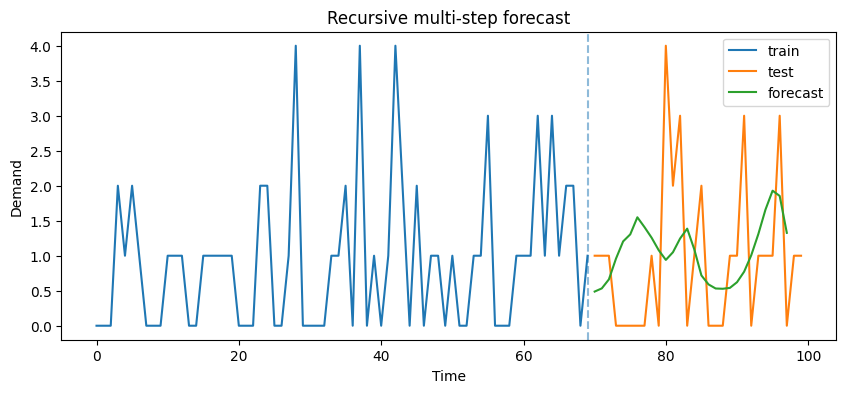

In [64]:
hist_idx   = np.arange(len(series))
val_idx = np.arange(len(series), len(series) + len(val_set.iloc[0].values))
out_idx = np.arange(len(series), len(series) + len(pred))

plt.figure(figsize=(10,4))
plt.plot(hist_idx, series, label="train")
plt.plot(val_idx, val_set.iloc[0].values, label="test")
plt.plot(out_idx, pred, label="forecast")

plt.axvline(len(series)-1, ls='--', alpha=.5)  # pemisah history vs future
plt.legend(); plt.xlabel('Time'); plt.ylabel('Demand'); plt.title('Recursive multi-step forecast')
plt.show()